In [1]:
import torch
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import torch.nn as nn
from torchvision import datasets
from tqdm import tqdm


/home2/sanika/miniconda3/envs/smai/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import wandb

In [3]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: sanika-damle (project-ai-scream). Use `wandb login --relogin` to force relogin


True

### Getting the CIFAR10 dataset

In [4]:
# download the cifar10 dataset
trainset = datasets.CIFAR10(root='/scratch/cifar10', train=True, download=True, transform=ToTensor())

100%|██████████| 170498071/170498071 [00:53<00:00, 3189343.40it/s] 


Extracting /scratch/cifar10/cifar-10-python.tar.gz to /scratch/cifar10


In [6]:
testset = datasets.CIFAR10(root='/scratch/cifar10', train=False, download=True, transform=ToTensor())

Files already downloaded and verified


In [7]:
# print length of trainset
print(len(trainset))

50000


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Visualising the Dataset

In [8]:
image, label = trainset[4]
print(image.shape)

torch.Size([3, 32, 32])


torch.Size([3, 32, 32]) 4


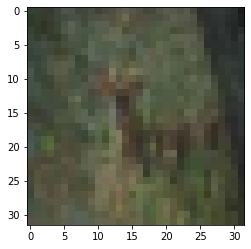

In [9]:
# print the first image
image, label = trainset[10]
print(image.shape, label)
plt.imshow(image.permute(1, 2, 0))


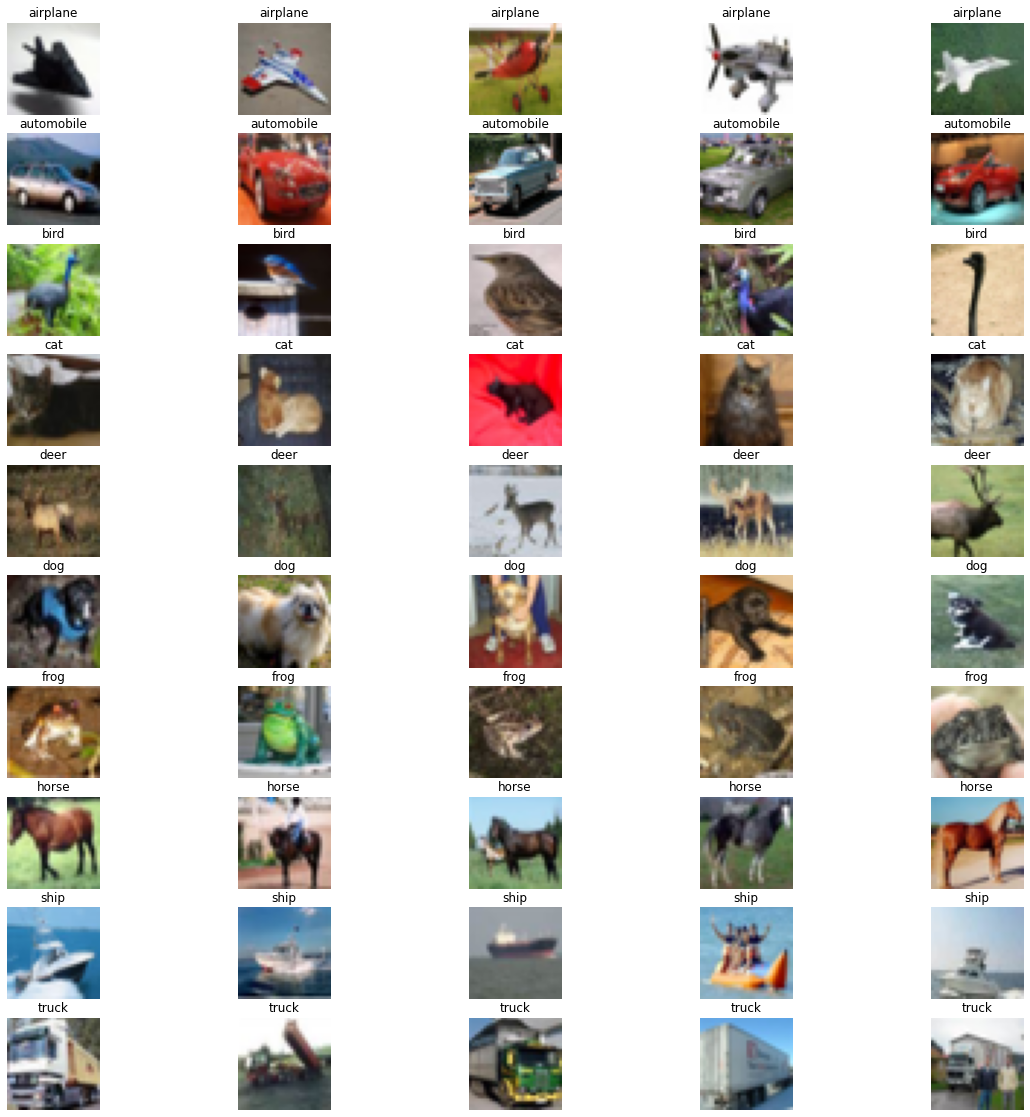

In [10]:
"""
    Visualises rhe first 5 images of each class in the training set
"""

class_counts = {class_name: 0 for class_name in trainset.classes}
columns = 5
rows = len(trainset.classes)

fig, axs = plt.subplots(rows, columns, figsize=(20, 20))

for i, (img, label) in enumerate(trainset):
    class_name = trainset.classes[label]
    
    if class_counts[class_name] < 5:
        row = trainset.class_to_idx[class_name]
        col = class_counts[class_name]
        
        axs[row, col].imshow(img.squeeze().permute(1, 2, 0))
        axs[row, col].set_title(class_name)
        axs[row, col].axis('off')
        
        class_counts[class_name] += 1

    if all(count >= 5 for count in class_counts.values()):
        break

plt.show()


### Loading the Dataset

In [9]:
loaders = {
    'train': DataLoader(trainset, batch_size=256, shuffle=True, num_workers=1),
    'test': DataLoader(testset, batch_size=512, shuffle=False, num_workers=1)
}

### VGG Class

In [6]:
class VGG16(nn.Module):
    def __init__(self, num_classes):
        super(VGG16, self).__init__()
        self.layer1 = nn.Sequential(   
            nn.Conv2d(3, 64, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.layer2 = nn.Sequential(   
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride = 1, padding = 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
        )
        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
        )   
        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer11 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
        )
        self.layer12 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
        )
        self.layer13 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer14 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(512, 4096),
            nn.ReLU(),
        )
        self.layer15 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
        )
        self.layer16 = nn.Sequential(
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out)
        out = self.layer11(out)
        out = self.layer12(out)
        out = self.layer13(out)
        out = out.view(out.size(0), -1)
        out = self.layer14(out)
        out = self.layer15(out)
        out = self.layer16(out)
        return out
   
    def fit(self, loaders, epochs, device, learning_rate):
        # open a txt file with the name as the epochs, learningrate
        # write the loss and accuracy into the file
        # make the file first
        # file = f"{learning_rate_str}epoch{epochs}.txt"
        # ftrain = open("train" + file, "a")
        # ftest = open("test" + file, "a")

    
        self.to(device)
        criterion = nn.CrossEntropyLoss().to(device)
        # adamoptimizer
        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        for epoch in tqdm(range(epochs)):
            self.train().to(device)

            total_loss = 0
            correct = 0
            total = 0

            for i, (images, labels) in enumerate(loaders['train']):
                self.train().to(device)
                optimizer.zero_grad()

                images = images.to(device)
                labels = labels.to(device)
                
                outputs = self(images)
                loss = criterion(outputs, labels)
                
                loss.backward()
                optimizer.step()

                total_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                # print accuracy and loss for each batch
                # save the loss and accuracy into a file
                if(i % 30 == 0):
                    # open file for training accuracy
                    wandb.log({"Epoch": epoch + 1, "Loss": total_loss / (i + 1), "Train_Accuracy": 100 *correct / total})
                    # ftrain.write(f'Epoch: {epoch + 1}, Batch: {i + 1}, Loss: {total_loss / (i + 1)}, Accuracy: {100 * correct / total}\n')

                # set to eval mode, find accuracy on trainset
                if(i % 30 == 0):
                    self.eval().to(device)
                    test_total = 0
                    test_correct = 0
                    for j, (imagestest, labelstest) in enumerate(loaders['test']):
                        imagestest = imagestest.to(device)
                        labelstest = labelstest.to(device)
                        outputstest = self(imagestest)
                        _, predictedtest = torch.max(outputstest.data, 1)
                        test_total += labelstest.size(0)
                        test_correct += (predictedtest == labelstest).sum().item()

                    # print accuracy and loss for each batch
                    # save the loss and accuracy into a file
                    wandb.log({"Epoch": epoch + 1, "Loss": total_loss / (i + 1), "TestAccuracy": 100 * test_correct / test_total})


In [7]:
torch.cuda.empty_cache()

### Logging into Wandb for different hyperparameters

In [11]:
sweep_config = {
    'method': 'grid',
    'metric': {
        'name': 'accuracy',
        'goal': 'maximize'
    },
    'parameters': {
        'learning_rate': {
            'values': [0.001, 0.0005, 0.0001]
        },
    }
}

In [12]:
sweep_id = wandb.sweep(sweep_config, project='batchnorm')

Create sweep with ID: kh2ps2rs
Sweep URL: https://wandb.ai/project-ai-scream/batchnorm/sweeps/kh2ps2rs


In [ ]:
def wandb_logging():
    with wandb.init() as run:
        lr = wandb.config.learning_rate
        run_name = f"with_batchnorm_cifar10_lr_{lr}"
        wandb.run.name = run_name
        model = VGG16(10).to(device)
        model.fit(loaders, epochs=50, device=device, learning_rate=lr)
# for lr in lrs:
#     model = VGG16(10).to(device)
#     model.fit(loaders, epochs=50, device=device, learning_rate=lr)
wandb.agent(sweep_id, function = wandb_logging)


In [72]:
secondmodel = VGG16(10).to(device)
f = open("./10_1.txt", "w")
f.close()
secondmodel.fit(loaders, epochs=15, device=device, learning_rate=0.1)

Epoch: 1, Loss: 2.0836, Accuracy: 18.19%
Epoch: 2, Loss: 1.9127, Accuracy: 22.62%
Epoch: 3, Loss: 1.8882, Accuracy: 23.91%
Epoch: 4, Loss: 1.8902, Accuracy: 24.43%
Epoch: 5, Loss: 1.8151, Accuracy: 28.36%
Epoch: 6, Loss: 1.7306, Accuracy: 31.28%
Epoch: 7, Loss: 1.7037, Accuracy: 32.67%
Epoch: 8, Loss: 1.6695, Accuracy: 34.37%
Epoch: 9, Loss: 1.6588, Accuracy: 34.84%
Epoch: 10, Loss: 1.6497, Accuracy: 35.92%
Epoch: 11, Loss: 1.6177, Accuracy: 37.66%
Epoch: 12, Loss: 1.5897, Accuracy: 39.40%
Epoch: 13, Loss: 1.5840, Accuracy: 39.43%
Epoch: 14, Loss: 1.5706, Accuracy: 40.98%
Epoch: 15, Loss: 1.5674, Accuracy: 41.65%


In [75]:
thirdmodel = VGG16(10).to(device)
f = open("./15_01.txt", "w")
f.close()
thirdmodel.fit(loaders, epochs=15, device=device, learning_rate=0.01)

Epoch: 1, Loss: 1.5327, Accuracy: 42.80%
Epoch: 2, Loss: 0.9974, Accuracy: 65.00%
Epoch: 3, Loss: 0.8021, Accuracy: 72.53%
Epoch: 4, Loss: 0.6875, Accuracy: 77.22%
Epoch: 5, Loss: 0.6090, Accuracy: 79.88%
Epoch: 6, Loss: 0.5448, Accuracy: 82.64%
Epoch: 7, Loss: 0.5027, Accuracy: 83.78%
Epoch: 8, Loss: 0.4714, Accuracy: 84.99%
Epoch: 9, Loss: 0.4415, Accuracy: 85.86%
Epoch: 10, Loss: 0.4342, Accuracy: 86.03%
Epoch: 11, Loss: 0.4161, Accuracy: 86.73%
Epoch: 12, Loss: 0.4032, Accuracy: 87.16%
Epoch: 13, Loss: 0.3964, Accuracy: 87.44%
Epoch: 14, Loss: 0.3774, Accuracy: 87.99%
Epoch: 15, Loss: 0.3722, Accuracy: 88.19%


## Without Batch Normalization

In [5]:
class VGG16_NoBatchNorm(nn.Module):
    def __init__(self, num_classes):
        super(VGG16_NoBatchNorm, self).__init__()
        self.layer1 = nn.Sequential(   
            nn.Conv2d(3, 64, kernel_size=3, padding=1, stride=1),
            # nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.layer2 = nn.Sequential(   
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            # nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride = 1, padding = 1),
            # nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1, stride=1),
            # nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1, stride=1),
            # nn.BatchNorm2d(256),
            nn.ReLU(),
        )
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1, stride=1),
            # nn.BatchNorm2d(256),
            nn.ReLU(),
        )
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1, stride=1),
            # nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1, stride=1),
            # nn.BatchNorm2d(512),
            nn.ReLU(),
        )
        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1, stride=1),
            # nn.BatchNorm2d(512),
            nn.ReLU(),
        )   
        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1, stride=1),
            # nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer11 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1, stride=1),
            # nn.BatchNorm2d(512),
            nn.ReLU(),
        )
        self.layer12 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1, stride=1),
            # nn.BatchNorm2d(512),
            nn.ReLU(),
        )
        self.layer13 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1, stride=1),
            # nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer14 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(512, 4096),
            nn.ReLU(),
        )
        self.layer15 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
        )
        self.layer16 = nn.Sequential(
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out)
        out = self.layer11(out)
        out = self.layer12(out)
        out = self.layer13(out)
        out = out.reshape(out.size(0), -1)
        out = self.layer14(out)
        out = self.layer15(out)
        out = self.layer16(out)
        return out
    
    def fit(self, loaders, epochs, device, learning_rate):
        # open a txt file with the name as the epochs, learningrate
        # write the loss and accuracy into the file
        # make the file first
        # file = f"{learning_rate_str}epoch{epochs}.txt"
        # ftrain = open("train" + file, "a")
        # ftest = open("test" + file, "a")

        self.to(device)
        criterion = nn.CrossEntropyLoss().to(device)
        # adamoptimizer
        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        for epoch in tqdm(range(epochs)):
            self.train().to(device)

            total_loss = 0
            correct = 0
            total = 0

            for i, (images, labels) in enumerate(loaders['train']):
                self.train().to(device)
                optimizer.zero_grad()

                images = images.to(device)
                labels = labels.to(device)
                
                outputs = self(images)
                loss = criterion(outputs, labels)
                
                loss.backward()
                optimizer.step()

                total_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                # print accuracy and loss for each batch
                # save the loss and accuracy into a file
                if(i % 30 == 0):
                    # open file for training accuracy
                    wandb.log({"Epoch": epoch + 1, "Loss": total_loss / (i + 1), "Train_Accuracy": 100 *correct / total})

                # set to eval mode, find accuracy on trainset
                if(i % 30 == 0):
                    self.eval().to(device)
                    test_total = 0
                    test_correct = 0
                    for j, (imagestest, labelstest) in enumerate(loaders['test']):
                        imagestest = imagestest.to(device)
                        labelstest = labelstest.to(device)
                        outputstest = self(imagestest)
                        _, predictedtest = torch.max(outputstest.data, 1)
                        test_total += labelstest.size(0)
                        test_correct += (predictedtest == labelstest).sum().item()
                    # print accuracy and loss for each batch
                    # save the loss and accuracy into a file
                    wandb.log({"Epoch": epoch + 1, "Loss": total_loss / (i + 1), "TestAccuracy": 100 * test_correct / test_total})

### Logging into Wandb for different hyperparameters for model without batch normalization

In [13]:
sweep_id = wandb.sweep(sweep_config, project='batchnorm')

Create sweep with ID: sgp6miuv
Sweep URL: https://wandb.ai/project-ai-scream/batchnorm/sweeps/sgp6miuv


In [15]:
def wandb_logging_without():
    with wandb.init() as run:
        lr = wandb.config.learning_rate
        run_name = f"without_batchnorm_cifar10_lr_{lr}"
        wandb.run.name = run_name
        model = VGG16_NoBatchNorm(10).to(device)
        model.fit(loaders, epochs=50, device=device, learning_rate=lr)

wandb.agent(sweep_id, function = wandb_logging_without)

wandb: Agent Starting Run: jv6hgaq7 with config:
wandb: 	learning_rate: 0.001
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


100%|██████████| 50/50 [19:03<00:00, 22.87s/it]


Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▄▄▄█▄▄▅▄▄▁▄▄▄▄▄▄▄▄▄▄▄▄▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄
TestAccuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train_Accuracy,▃▃▃▃▃▄▃▁▃▃█▃▄▃▃▃▃▃▃▃▃▃▃▄▄▃▄▃▃▃▃▄▃▃▃▃▃▃▃▃
Epoch,50
Loss,2.30266
TestAccuracy,10.0
Train_Accuracy,9.75268


wandb: Agent Starting Run: e5pn49cz with config:
wandb: 	learning_rate: 0.0005
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


100%|██████████| 50/50 [19:03<00:00, 22.87s/it]


Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,██▇▆▆▅▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
TestAccuracy,▁▂▂▃▄▆▇▇▇▇██████████████████████████████
Train_Accuracy,▁▁▂▂▃▄▅▆▆▆▆▇▇▇▇▇▇███████████████████████
Epoch,50
Loss,0.04782
TestAccuracy,77.93
Train_Accuracy,98.57346


wandb: Agent Starting Run: 3enc6udx with config:
wandb: 	learning_rate: 0.0001
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


100%|██████████| 50/50 [18:30<00:00, 22.22s/it]


Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▆▅▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
TestAccuracy,▁▂▃▄▅▅▆▆▆▇▇▇▇▇▇▇████████████████████████
Train_Accuracy,▁▂▂▃▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇█████████████████
Epoch,50
Loss,0.05104
TestAccuracy,76.3
Train_Accuracy,98.35765


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


### Performing the above experiment for the CIFAR100 dataset

In [6]:
# run on cifar 100
train_100 = datasets.CIFAR100(root='/scratch/cifar100', train=True, download=True, transform=ToTensor())

Files already downloaded and verified


In [7]:
test_100 = datasets.CIFAR100(root='/scratch/cifar100', train=False, download=True, transform=ToTensor())

Files already downloaded and verified


In [8]:
loader_100 = {
    'train': DataLoader(train_100, batch_size=256, shuffle=True, num_workers=1),
    'test': DataLoader(test_100, batch_size=512, shuffle=False, num_workers=1)
}

torch.Size([3, 32, 32]) 19


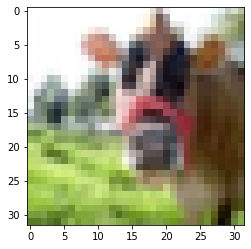

In [11]:
# print first image
image, label = train_100[0]
print(image.shape, label)
plt.imshow(image.permute(1, 2, 0))

In [9]:
sweep_config = {
    'method': 'grid',
    'metric': {
        'name': 'accuracy',
        'goal': 'maximize'
    },
    'parameters': {
        'learning_rate': {
            'values': [0.0003]
        },
    }
}

In [10]:
sweep_id = wandb.sweep(sweep_config, project='batchnorm')

Create sweep with ID: bkttik6x
Sweep URL: https://wandb.ai/project-ai-scream/batchnorm/sweeps/bkttik6x


In [11]:
def wandb_logging():
    with wandb.init() as run:
        lr = wandb.config.learning_rate
        run_name = f"without_batchnorm_cifar100_lr_{lr}"
        wandb.run.name = run_name
        model = VGG16_NoBatchNorm(100).to(device)
        model.fit(loader_100, epochs=50, device=device, learning_rate=lr)
# for lr in lrs:
#     model = VGG16(10).to(device)
#     model.fit(loaders, epochs=50, device=device, learning_rate=lr)
wandb.agent(sweep_id, function = wandb_logging)

wandb: Agent Starting Run: g5ca3vk7 with config:
wandb: 	learning_rate: 0.0003
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


100%|██████████| 50/50 [18:23<00:00, 22.06s/it]


Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,████▇▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁
TestAccuracy,▁▁▁▁▂▂▂▃▃▄▄▄▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇█████████████
Train_Accuracy,▁▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇██
Epoch,50
Loss,1.5165
TestAccuracy,27.36
Train_Accuracy,55.84211


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.
